This version of the snake game allows you to implement and run your evolutionary algorithm

In [1]:
import random
import time
import turtle


import copy
import random
import numpy
#import pygraphviz as pgv
from IPython.display import clear_output
from functools import partial

from deap import base
from deap import creator
from deap import tools
from deap import gp

In [2]:
XSIZE = YSIZE = 16 # Number of grid cells in each direction (do not change this)

Change headless to True when evolving your solution. You can then pickle your final solution, and run it with this set to True to visualize the result, if you wish. Note that, when using Turtle,  to run it again properly you might need to go to restart your kernel after the visualization has finished.

If you are running on the cloud, or on Google Colab, you can chose to remove the turtle and display code altogether and only run headless. You could then pickle your best solution and use this code to see it play.

In [3]:
HEADLESS = False

In [4]:
class DisplayGame:
    def __init__(self, XSIZE, YSIZE):
        # SCREEN
        self.win = turtle.Screen()
        self.win.title("EVCO Snake game")
        self.win.bgcolor("grey")
        self.win.setup(width=(XSIZE*20)+40,height=(YSIZE*20)+40)
        #self.win.screensize((XSIZE*20)+20,(YSIZE*20)+20)
        self.win.tracer(0)

        #Snake Head
        self.head = turtle.Turtle()
        self.head.shape("square")
        self.head.color("black")

        # Snake food
        self.food = turtle.Turtle()
        self.food.shape("circle")
        self.food.color("yellow")
        self.food.penup()
        self.food.shapesize(0.55, 0.55)
        self.segments = []

    def reset(self, snake):
        self.segments = []
        self.head.penup()
        self.food.goto(-500, -500)
        self.head.goto(-500, -500)
        for i in range(len(snake)-1):
            self.add_snake_segment()
        self.update_segment_positions(snake)
       
    def update_food(self,new_food):
        self.food.goto(((new_food[1]-9)*20)+20, (((9-new_food[0])*20)-10)-20)
        
    def update_segment_positions(self, snake):
        self.head.goto(((snake[0][1]-9)*20)+20, (((9-snake[0][0])*20)-10)-20)
        for i in range(len(self.segments)):
            self.segments[i].goto(((snake[i+1][1]-9)*20)+20, (((9-snake[i+1][0])*20)-10)-20)

    def add_snake_segment(self):
        self.new_segment = turtle.Turtle()
        self.new_segment.speed(0)
        self.new_segment.shape("square")
        self.new_segment.color(random.choice(["green",'black','red','blue']))
        self.new_segment.penup()
        self.segments.append(self.new_segment)

In [5]:
class snake:
    def __init__(self, _XSIZE, _YSIZE):
        self.XSIZE = _XSIZE
        self.YSIZE = _YSIZE
        self.reset()

    def reset(self):
        self.snake = [[8,10], [8,9], [8,8], [8,7], [8,6], [8,5], [8,4], [8,3], [8,2], [8,1],[8,0] ]# Initial snake co-ordinates [ypos,xpos]    
        self.food = self.place_food()
        #self.ahead = []
        self.left = []
        self.right = []
        self.up = []
        self.down = []
        self.snake_direction = "right"

    def place_food(self):
        self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        while (self.food in self.snake):
            self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        return( self.food )
    
    def update_snake_position(self):
        self.snake.insert(0, [self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1), self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)])

    def food_eaten(self):
        if self.snake[0] == self.food:                                            # When snake eats the food
            return True
        else:    
            last = self.snake.pop()  # [1] If it does not eat the food, it moves forward and so last tail item is removed
            return False
            
    def snake_turns_into_self(self):
        if self.snake[0] in self.snake[1:]:
            return True
        else:
            return False

    def snake_hit_wall(self):
        if self.snake[0][0] == 0 or self.snake[0][0] == (YSIZE-1) or self.snake[0][1] == 0 or self.snake[0][1] == (XSIZE-1):
            return True
        else:
            return False

    # Example sensing functions
    def getLeftLocation(self):
        self.left = [ self.snake[0][0] - 1, self.snake[0][0] ]
        
    def sense_wall_left(self):
        self.getLeftLocation()
        return( self.left[0] == 0 or self.left[0] == (YSIZE-1) or self.left[1] == 0 or self.left[1] == (XSIZE-1) )
        
    def if_wall_left(self, out1, out2):
        return partial(if_then_else, self.sense_wall_left, out1, out2) 
        
    def sense_food_left(self):
        self.getLeftLocation()
        return self.food == self.left
    
    def if_food_left(self, out1, out2):
        return partial(if_then_else, self.sense_food_left, out1, out2) 

    def sense_tail_left(self):
        self.getLeftLocation()
        return self.left in self.snake
    
    def if_tail_left(self, out1, out2):
        return partial(if_then_else, self.sense_tail_left, out1, out2) 
        
    def getRightLocation(self):
        self.right = [ self.snake[0][0] + 1, self.snake[0][0] ]
        
    def sense_wall_right(self):
        self.getRightLocation()
        return( self.right[0] == 0 or self.right[0] == (YSIZE-1) or self.right[1] == 0 or self.right[1] == (XSIZE-1) )
        
    def if_wall_right(self, out1, out2):
        return partial(if_then_else, self.sense_wall_right, out1, out2) 
        
    def sense_food_right(self):
        self.getRightLocation()
        return self.food == self.right
    
    def if_food_right(self, out1, out2):
        return partial(if_then_else, self.sense_food_right, out1, out2) 

    def sense_tail_right(self):
        self.getRightLocation()
        return self.right in self.snake
    
    def if_tail_right(self, out1, out2):
        return partial(if_then_else, self.sense_tail_right, out1, out2) 
        
    def getUpLocation(self):
        self.up = [ self.snake[0][0], self.snake[0][0] + 1 ]
        
    def sense_wall_up(self):
        self.getUpLocation()
        return( self.up[0] == 0 or self.up[0] == (YSIZE-1) or self.up[1] == 0 or self.up[1] == (XSIZE-1) )
        
    def if_wall_up(self, out1, out2):
        return partial(if_then_else, self.sense_wall_up, out1, out2) 
        
    def sense_food_up(self):
        self.getUpLocation()
        return self.food == self.up
    
    def if_food_up(self, out1, out2):
        return partial(if_then_else, self.sense_food_up, out1, out2) 

    def sense_tail_up(self):
        self.getUpLocation()
        return self.up in self.snake
    
    def if_tail_up(self, out1, out2):
        return partial(if_then_else, self.sense_tail_up, out1, out2)     
        
    def getDownLocation(self):
        self.down = [ self.snake[0][0], self.snake[0][0] - 1 ]

    def sense_wall_down(self):
        self.getDownLocation()
        return( self.down[0] == 0 or self.down[0] == (YSIZE-1) or self.down[1] == 0 or self.down[1] == (XSIZE-1) )
        
    def if_wall_down(self, out1, out2):
        return partial(if_then_else, self.sense_wall_down, out1, out2) 
        
    def sense_food_down(self):
        self.getDownLocation()
        return self.food == self.down
    
    def if_food_down(self, out1, out2):
        return partial(if_then_else, self.sense_food_down, out1, out2) 

    def sense_tail_down(self):
        self.getDownLocation()
        return self.down in self.snake
    
    def if_tail_down(self, out1, out2):
        return partial(if_then_else, self.sense_tail_down, out1, out2)     
        
    def getAheadLocation(self):
        self.ahead = [ self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1), self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)] 
        
    def sense_wall_ahead(self):
        self.getAheadLocation()
        return( self.ahead[0] == 0 or self.ahead[0] == (YSIZE-1) or self.ahead[1] == 0 or self.ahead[1] == (XSIZE-1) )
        
    def if_wall_ahead(self, out1, out2):
        return partial(if_then_else, self.sense_wall_ahead, out1, out2) 
        
    def sense_food_ahead(self):
        self.getAheadLocation()
        return self.food == self.ahead
    
    def if_food_ahead(self, out1, out2):
        return partial(if_then_else, self.sense_food_ahead, out1, out2) 

    def sense_tail_ahead(self):
        self.getAheadLocation()
        return self.ahead in self.snake
    
    def if_tail_ahead(self, out1, out2):
        return partial(if_then_else, self.sense_tail_ahead, out1, out2)     

    def sense_food_on_axis(self):
        return (self.snake[0][0] == self.food[0]) or (self.snake[0][1] == self.food[1]) 
    
    def if_food_on_axis(self, out1, out2):
        return partial(if_then_else, self.sense_food_on_axis, out1, out2) 
    
    def sense_food_leftwards(self):
        return (self.sense_food_on_axis and (self.snake[0][0] < self.food[0]))
    
    def if_food_leftwards(self, out1, out2):
        return partial(if_then_else, self.sense_food_leftwards, out1, out2)
    
    def sense_food_rightwards(self):
        return (self.sense_food_on_axis and (self.snake[0][0] > self.food[0]))
    
    def if_food_rightwards(self, out1, out2):
        return partial(if_then_else, self.sense_food_rightwards, out1, out2)
    
    def sense_food_upwards(self):
        return (self.sense_food_on_axis and (self.snake[0][1] > self.food[1]))
    
    def if_food_upwards(self, out1, out2):
        return partial(if_then_else, self.sense_food_upwards, out1, out2)
    
    def sense_food_downwards(self):
        return (self.sense_food_on_axis and (self.snake[0][1] < self.food[1]))
    
    def if_food_downwards(self, out1, out2):
        return partial(if_then_else, self.sense_food_downwards, out1, out2)
        
    def turn_right(self):
        self.snake_direction = "right"
    
    def turn_left(self):
        self.snake_direction = "left"
    
    def turn_up(self):
        self.snake_direction = "up"
    
    def turn_down(self):
        self.snake_direction = "down"

In [6]:
snake_game = snake(XSIZE,YSIZE)

In [7]:
if not HEADLESS:
    display = DisplayGame(XSIZE,YSIZE)

In [8]:
def run_game(display,snake_game, routine, headless):
    steps = 0
    score = 0
    snake_game.reset()
    if not headless:
        display.reset(snake_game.snake)
        display.win.update()
    snake_game.place_food()
    game_over = False
    snake_direction = "right"

    flag = True
    while not game_over:
        routine()
        snake_game.update_snake_position()
        steps += 1
        
        if steps == 1000: game_over = True
            
        # Check if food is eaten
        if snake_game.food_eaten():
            snake_game.place_food()
            steps = 0
            score += 1
            if not headless: display.add_snake_segment()

        # Game over if the snake runs over itself
        if snake_game.snake_turns_into_self():
            game_over = True
            #print("Snake turned into itself!")

        # Game over if the snake goes through a wall
        if snake_game.snake_hit_wall():
            game_over = True
            #print("Snake hit a wall!")

        if not headless:       
            display.update_food(snake_game.food)
            display.update_segment_positions(snake_game.snake)
            display.win.update()
            time.sleep(0.2) # Change this to modify the speed the game runs at when displayed.
            
    return score, steps
    if not headless: turtle.done()


In [9]:
pset = gp.PrimitiveSet("MAIN",0)

In [10]:
def progn(*args):
    for arg in args:
        arg()
        
def prog2(out1, out2): 
    return partial(progn,out1,out2)

def prog3(out1, out2, out3):
    return partial(progn,out1,out2,out3)

def prog4(out1, out2, out3, out4):
    return partial(progn,out1,out2,out3,out4)

def if_then_else(condition, out1, out2):
    out1() if condition() else out2()
    
pset.addPrimitive(snake_game.if_wall_up,2)
pset.addPrimitive(snake_game.if_food_upwards,2)
pset.addPrimitive(snake_game.if_tail_up,2)
pset.addPrimitive(snake_game.if_wall_left,2)
pset.addPrimitive(snake_game.if_food_leftwards,2)
pset.addPrimitive(snake_game.if_tail_left,2)
pset.addPrimitive(snake_game.if_wall_right,2)
pset.addPrimitive(snake_game.if_food_rightwards,2)
pset.addPrimitive(snake_game.if_tail_right,2)
pset.addPrimitive(snake_game.if_wall_down,2)
pset.addPrimitive(snake_game.if_food_downwards,2)
pset.addPrimitive(snake_game.if_tail_down,2)
pset.addPrimitive(prog2, 2)
pset.addPrimitive(prog3, 3)
pset.addPrimitive(prog4, 4)

pset.addTerminal(snake_game.turn_right)
pset.addTerminal(snake_game.turn_left)
pset.addTerminal(snake_game.turn_up)
pset.addTerminal(snake_game.turn_down)

In [11]:
creator.create("MultiFitness", base.Fitness, weights=(50.0,1.0,-0.1))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.MultiFitness)

In [12]:
toolbox = base.Toolbox()
toolbox.register("expr_init", gp.genHalfAndHalf, pset=pset, min_=2, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr_init)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [13]:
toolbox.register("select", tools.selDoubleTournament, fitness_size = 7, parsimony_size = 1.4, fitness_first = True)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=5)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [14]:
def evaluate(individual):
    routine = gp.compile(individual, pset)
    individual_score_total, individual_steps_total = 0, 0
    for attempt in range(3):
        individual_score, individual_steps = run_game(display,snake_game, routine, headless=True)
        individual_score_total += individual_score
        individual_steps_total += individual_steps
    return individual_score_total, individual_steps_total, individual.height

toolbox.register("evaluate", evaluate)

In [15]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
stats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)

stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

In [16]:
logbook = tools.Logbook()
pop = toolbox.population(n=500)

NGEN, CXPB, MUTPB = 200, 0.2, 0.2
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit
    
for g in range(NGEN):
    clear_output(wait=True)
    print("-- Generation %i --" % g)
    
    offspring = toolbox.select(pop, len(pop))

    offspring = list(map(toolbox.clone, offspring))
    
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
            
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
        
    Neval = len(invalid_ind) 
    pop[:] = offspring
    
    record = stats.compile(pop)
    
    logbook.record(gen=g, evals=Neval, **record)

-- Generation 199 --


In [17]:
pset_original = gp.PrimitiveSet("MAIN",0)
    
pset_original.addPrimitive(snake_game.if_wall_ahead,2)
pset_original.addPrimitive(snake_game.if_food_ahead,2)
pset_original.addPrimitive(snake_game.if_tail_ahead,2)
pset_original.addPrimitive(prog2, 2)
pset_original.addPrimitive(prog3, 3)
pset_original.addPrimitive(prog4, 4)

pset_original.addTerminal(snake_game.turn_right)
pset_original.addTerminal(snake_game.turn_left)
pset_original.addTerminal(snake_game.turn_up)
pset_original.addTerminal(snake_game.turn_down)

In [18]:
toolbox.register("expr_init", gp.genHalfAndHalf, pset=pset_original, min_=2, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr_init)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset_original)

def evaluate_original(individual):
    routine = gp.compile(individual, pset_original)
    individual_score_total, individual_steps_total = 0, 0
    for attempt in range(3):
        individual_score, individual_steps = run_game(display,snake_game, routine, headless=True)
        individual_score_total += individual_score
        individual_steps_total += individual_steps
    return individual_score_total, individual_steps_total, individual.height

toolbox.register("evaluate_original", evaluate_original)

logbook_original = tools.Logbook()
pop_original = toolbox.population(n=500)

fitnesses = list(map(toolbox.evaluate_original, pop_original))
for ind, fit in zip(pop_original, fitnesses):
    ind.fitness.values = fit
    
for g in range(NGEN):
    clear_output(wait=True)
    print("-- Generation %i --" % g)
    
    offspring = toolbox.select(pop_original, len(pop_original))

    offspring = list(map(toolbox.clone, offspring))
    
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
            
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate_original, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
        
    Neval = len(invalid_ind) 
    pop_original[:] = offspring
    
    record = stats.compile(pop_original)
    
    logbook_original.record(gen=g, evals=Neval, **record)

-- Generation 199 --


Text(0, 0.5, 'Fitness')

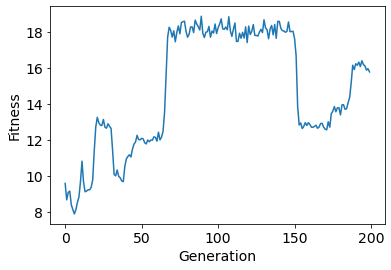

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

gen = logbook.chapters['fitness'].select("gen")
_min = logbook.chapters['fitness'].select("min")
_max = logbook.chapters['fitness'].select("max")
avgs = logbook.chapters['fitness'].select("avg")
stds = logbook.chapters['fitness'].select("std")

gen_original = logbook_original.chapters['fitness'].select("gen")
_min_original = logbook_original.chapters['fitness'].select("min")
_max_original = logbook_original.chapters['fitness'].select("max")
avgs_original = logbook_original.chapters['fitness'].select("avg")
stds_original = logbook_original.chapters['fitness'].select("std")

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(gen, _min)
line3 = ax1.plot(gen, _max)

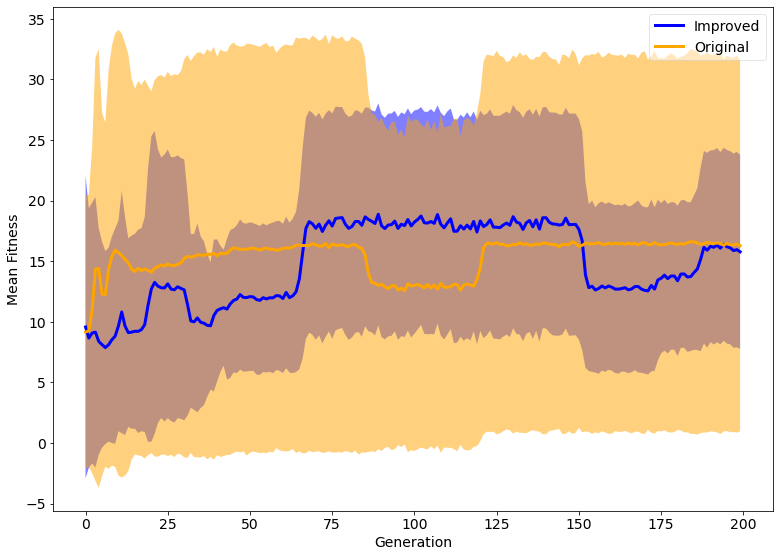

In [20]:
plt.rcParams.update({'font.size': 20})

fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_axes([0, 0, 1, 1]) 
ax.set_xlabel('Generation')
ax.set_ylabel('Mean Fitness')
ax.plot(gen, avgs, lw=3, label='Improved', color='blue')
ax.fill_between(gen, [i + j for i, j in zip(avgs, stds)], [i - j for i, j in zip(avgs, stds)], facecolor='blue', alpha=0.5)
ax.plot(gen, avgs_original, lw=3, label='Original', color='orange')
ax.fill_between(gen, [i + j for i, j in zip(avgs_original, stds_original)], [i - j for i, j in zip(avgs_original, stds_original)], facecolor='orange', alpha=0.5)
ax.legend(loc='best', fancybox=True, framealpha=0.5)

<ipython-input-21-c19efdae102f>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Improved', 'Original'])


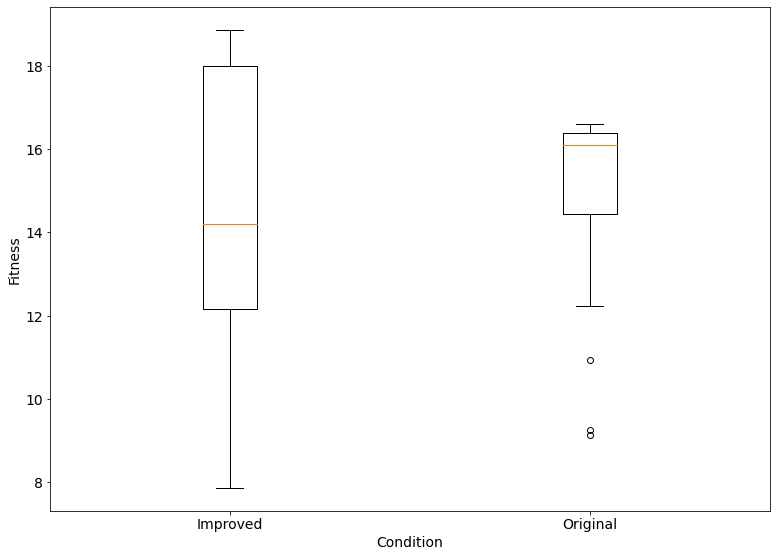

In [21]:
data = [avgs, avgs_original] 
fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_axes([0, 0, 1, 1]) 
ax.set_xticklabels(['Improved', 'Original']) 

ax.set_xlabel('Condition')
ax.set_ylabel('Fitness')

bp = ax.boxplot(data)

In [22]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(avgs, avgs_original)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=19465.500, p=0.322


In [23]:
indv = tools.selBest(pop,1)[0]
print(indv)
print(indv.height)

if_food_rightwards(if_wall_up(turn_up, if_food_downwards(turn_right, turn_up)), if_tail_right(if_wall_up(turn_up, if_tail_left(if_tail_down(if_food_upwards(turn_right, turn_right), turn_down), if_food_downwards(if_tail_left(turn_right, prog3(if_tail_left(if_tail_up(turn_down, if_food_downwards(prog2(turn_right, turn_left), prog4(turn_right, turn_up, turn_right, turn_left))), if_wall_left(if_tail_down(prog2(turn_down, turn_right), prog3(turn_down, turn_right, turn_left)), if_wall_right(if_tail_right(turn_left, turn_left), if_food_downwards(turn_right, turn_right)))), if_wall_right(if_wall_left(if_tail_down(prog2(turn_down, turn_right), prog3(turn_down, turn_right, turn_left)), if_wall_right(if_tail_right(turn_left, turn_left), if_food_downwards(turn_right, turn_right))), prog2(if_tail_down(if_tail_right(turn_up, turn_up), if_tail_up(turn_right, turn_down)), if_food_upwards(prog2(turn_right, turn_right), prog3(turn_left, turn_down, turn_left)))), prog2(prog3(if_food_downwards(if_tail_rig

In [24]:
indv_original = tools.selBest(pop_original,1)[0]
print(indv_original)
print(indv_original.height)

prog2(prog4(if_wall_ahead(prog3(turn_right, turn_left, turn_right), prog3(turn_up, turn_right, turn_left)), if_tail_ahead(prog4(turn_right, turn_up, turn_down, turn_up), if_wall_ahead(turn_up, turn_right)), prog4(if_wall_ahead(turn_down, turn_left), prog4(turn_right, turn_down, turn_up, turn_up), if_food_ahead(turn_up, turn_down), if_food_ahead(prog4(turn_right, turn_down, turn_down, turn_right), if_wall_ahead(turn_up, turn_up))), if_food_ahead(prog4(turn_right, turn_down, turn_down, turn_right), if_wall_ahead(turn_up, turn_up))), prog4(if_wall_ahead(prog4(turn_left, turn_down, turn_down, turn_down), prog3(turn_down, if_tail_ahead(prog4(if_wall_ahead(turn_down, turn_right), prog3(turn_up, turn_right, turn_up), prog3(turn_down, turn_up, turn_right), if_food_ahead(turn_down, turn_left)), prog2(if_tail_ahead(turn_up, turn_right), if_food_ahead(turn_down, turn_left))), turn_down)), if_tail_ahead(prog4(turn_left, turn_right, turn_right, turn_down), if_food_ahead(turn_down, turn_down)), prog

In [25]:
#nodes, edges, labels = gp.graph(indv)
#
#tree = pgv.AGraph()
#tree.add_nodes_from(nodes)
#tree.add_edges_from(edges)
#tree.layout(prog="dot")
#
#for i in nodes:
#    n = tree.get_node(i)
#    n.attr["label"] = labels[i]

In [26]:
#from IPython.display import Image
#
#treePlot = tree.draw(format='png', prog='dot')
#Image(treePlot)

In [ ]:
while True: run_game(display, snake_game, gp.compile(indv, pset), headless=HEADLESS)